In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from IPython.display import display

%matplotlib inline

# Какъв е дейтасета?
[Dataset-a](https://www.kaggle.com/rio2016/olympic-games) е за олимпийските игри в Рио. Той съдържа три файла - athletes, events, countries. За жалост няма начин да се свържат атлетите със състезанията, в които са участвали затова events изобщо няма да се ползва.
# Какво ще предричаме?
Интересен въпрос е дали на базата на характеристиките в дейтасета може да се предрече за даден атлет колко медала е спечелил.

In [2]:
athletes = pd.read_csv("OlympicGames/data/athletes.csv", encoding="ISO-8859-1")
countries = pd.read_csv("OlympicGames/data/countries.csv", encoding="ISO-8859-1")
print(athletes.shape)
athletes[:5]

(11538, 11)


,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0


In [3]:
print(countries.shape)
countries[:5]

(201, 4)


,country,code,population,gdp_per_capita
0,Afghanistan,AFG,32526562.0,594.323081
1,Albania,ALB,2889167.0,3945.217582
2,Algeria,ALG,39666519.0,4206.031232
3,American Samoa*,ASA,55538.0,NaN
4,Andorra,AND,70473.0,NaN


Очаквам, че feature-ите population и gdp_per_capita ще оказват влияние върху качествата на спортистите(по-богатите държави могат да си позволят по-добра подготовка, а когато избираш най-добрите от голямо население има по-голям шанс да избереш най-добрите въобще). 

По тези причини да свържем двете таблици. 

In [4]:
athletes_with_country = pd.merge(athletes, countries, left_on="nationality", right_on="code")
athletes_with_country[:5]

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze,country,code,population,gdp_per_capita
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0,Spain,ESP,46418269.0,25831.582305
1,87689776,Aauri Lorena Bokesa,ESP,female,12/14/88,1.80,62.0,athletics,0,0,0,Spain,ESP,46418269.0,25831.582305
2,803161695,Abdelaziz Merzougui,ESP,male,8/30/91,1.75,67.0,athletics,0,0,0,Spain,ESP,46418269.0,25831.582305
3,302277635,Adel Mechaal,ESP,male,12/5/90,1.82,71.0,athletics,0,0,0,Spain,ESP,46418269.0,25831.582305
4,400838338,Adrian Gavira Collado,ESP,male,9/17/87,1.93,89.0,volleyball,0,0,0,Spain,ESP,46418269.0,25831.582305


In [5]:
athletes_with_country.shape

(11231, 15)

След сливането част от атлетите отпаднаха, изглежда има разминаване в IOC кодовете. Да видим.

In [6]:
ioc_not_in_countries = set(athletes.nationality) - set(countries.code)
ioc_not_in_countries

{'IOA', 'KIR', 'KOS', 'MHL', 'MNE', 'ROT', 'ROU', 'SRB', 'SSD', 'TTO', 'TUV'}

In [7]:
ioc_to_country = {"ROU": "Romania" ,"SRB": "Serbia","TTO": "Trinidad and Tobago"}

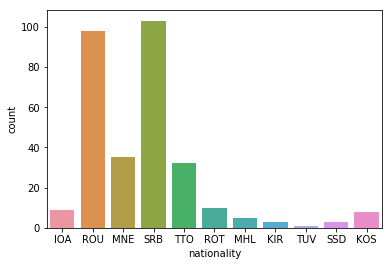

In [8]:
sns.countplot(x="nationality", data=athletes[athletes.nationality.isin(ioc_not_in_countries)])

Най-много разминаване има при Румъния, Сърбия, Черна гора, Тринидад и тобаго. IOA са независими състезатели а ROT са бежанци, за тях трудно ще се намери информация. Останалите са много малко на брой.

In [9]:
countries[countries.country.isin(ioc_to_country.values())]

,country,code,population,gdp_per_capita
149,Romania,ROM,19832389.0,8972.922518
160,Serbia,SCG,7098247.0,5235.142207
183,Trinidad and Tobago,TRI,1360088.0,17321.884675


Изглежда за три от държавите има информация, просто са записани със стари ICO кодове. За черна гора няма информация. Айде, от мен да мине, ще ги уважа и тях.

In [10]:
montenegro = pd.DataFrame([["Montenegro", "MNE", 622781, 6701]], columns=list(countries.columns.values))
countries = countries.append(montenegro, ignore_index=True)

Остана да променя кодовете на Сърбия, Румъния, Тринидад и Тобаго.

In [11]:
countries.loc[countries.country == "Romania", "code"] = "ROU"
countries.loc[countries.country == "Serbia", "code"] = "SRB"
countries.loc[countries.country == "Trinidad and Tobago", "code"] = "TTO"

In [12]:
countries[countries.country.isin(ioc_to_country.values())]

,country,code,population,gdp_per_capita
149,Romania,ROU,19832389.0,8972.922518
160,Serbia,SRB,7098247.0,5235.142207
183,Trinidad and Tobago,TTO,1360088.0,17321.884675


Опитваме сливането отново.

In [13]:
athletes_with_countries = pd.merge(athletes, countries, left_on="nationality", right_on="code")
athletes_with_countries.shape

(11499, 15)

Сега губим само 39 спортиста. Close enough.

Колоните nationality и code са едни и същи, но и двете са излишни защото са в биекция с country. Името също така не е определящ фактор за спечелването на медали. Затова премахвам трите колони. Id също не върши работа.

In [14]:
athletes_with_countries = athletes_with_countries.drop(["nationality", "code", "name", "id"], axis=1)
athletes_with_countries[:5]

,sex,dob,height,weight,sport,gold,silver,bronze,country,population,gdp_per_capita
0,male,10/17/69,1.72,64.0,athletics,0,0,0,Spain,46418269.0,25831.582305
1,female,12/14/88,1.80,62.0,athletics,0,0,0,Spain,46418269.0,25831.582305
2,male,8/30/91,1.75,67.0,athletics,0,0,0,Spain,46418269.0,25831.582305
3,male,12/5/90,1.82,71.0,athletics,0,0,0,Spain,46418269.0,25831.582305
4,male,9/17/87,1.93,89.0,volleyball,0,0,0,Spain,46418269.0,25831.582305


Сега да видим кои колони имат празни стойности.

In [15]:
athletes_with_countries.isnull().sum().sort_values()

sex                 0
sport               0
gold                0
silver              0
bronze              0
country             0
dob                 1
population         83
height            325
gdp_per_capita    509
weight            654
dtype: int64

Липсват стойности в потенциално най-важните колони. Ще трябва да ги попълня.
Преди това ще създам нови колони medals_won = общия брой спечелени медали и възраст извлечена от dob колоната.

In [16]:
athletes_with_countries["medals_won"] = athletes_with_countries["gold"] + athletes_with_countries["silver"] + athletes_with_countries["bronze"]

In [17]:
athletes_with_countries.isnull().sum().sort_values()

sex                 0
sport               0
gold                0
silver              0
bronze              0
country             0
medals_won          0
dob                 1
population         83
height            325
gdp_per_capita    509
weight            654
dtype: int64

Има само едно празно dob, запълвам го с разумно очакване за средна година на раждане на участник в олимпиадата.

In [18]:
athletes_with_countries["dob"] = athletes_with_countries.dob.fillna("/94")

In [19]:
import datetime
import re
year_now = datetime.datetime.now().year


def get_age_from_dob(row):
    match_obj = re.search(r'/([0-9]+)$', row.dob, flags=0)
    year = pd.to_numeric(match_obj.group(1), errors='coerce')
    if year < 20:
        # most likely born in 20**
        return year_now - (2000 + year)
    else:
        # most likely born in 19**
        return year_now - (1900 + year)

In [20]:
athletes_with_countries["age"] = athletes_with_countries.apply(lambda row: get_age_from_dob (row), axis=1)

In [21]:
athletes_with_countries.isnull().sum().sort_values()

sex                 0
dob                 0
sport               0
gold                0
silver              0
bronze              0
country             0
medals_won          0
age                 0
population         83
height            325
gdp_per_capita    509
weight            654
dtype: int64

След като имам възрастта dob повече не ми трябва.

In [22]:
athletes_with_countries = athletes_with_countries.drop(["dob"], axis=1)

Да видим кои държави нямат gdp_per_capita. 

In [23]:
athletes = athletes_with_countries
countries_missing_gdp = athletes[athletes["gdp_per_capita"].isnull()].country.unique()
countries_missing_gdp

array(['Eritrea', 'Iran', 'Cuba', 'Puerto Rico*', 'Libya',
       'Palestine, Occupied Territories', 'Venezuela', 'Taiwan',
       'San Marino', 'Cook Islands', 'Aruba*', 'British Virgin Islands',
       'Syria', 'Guam', 'American Samoa*', 'Monaco', 'Bermuda*',
       'Virgin Islands*', 'Korea, North', 'Liechtenstein', 'Andorra',
       'Cayman Islands*', 'Mauritania', 'Papua New Guinea'], dtype=object)

След няколко "бързи" google search-a намирам съответните нужни стойности.

In [24]:
country_to_gdp_per_capita = {"Eritrea": 582.78, "Iran": 4957.58, "Cuba": 7602.26,
                             "Puerto Rico*": 28703.75, "Libya": 5602.55, "Palestine, Occupied Territories": 1745.90,
                             "Venezuela": 12237.22, "Taiwan": 31900.00, "San Marino": 62596.95, "Cook Islands": 9100.00,
                             "Aruba*": 25324.72, "British Virgin Islands": 38500.00,
                             "Syria": 2058.04, "Guam": 35439.47, "American Samoa*": 11541.85,
                             "Monaco": 162009.88, "Bermuda*": 85748.07, "Virgin Islands*": 36350.82,
                             "Korea, North": 583.00, "Liechtenstein": 179478.58, "Andorra": 40215.44, "Cayman Islands*": 64100.91,
                             "Mauritania": 1077.56, "Papua New Guinea": 2182.72}

In [25]:
def fill_in_gdp(athletes):
    for country in countries_missing_gdp:
        athletes.loc[athletes.country == country, "gdp_per_capita"] = country_to_gdp_per_capita[country]

In [26]:
fill_in_gdp(athletes)
athletes.isnull().sum().sort_values()

sex                 0
sport               0
gold                0
silver              0
bronze              0
country             0
gdp_per_capita      0
medals_won          0
age                 0
population         83
height            325
weight            654
dtype: int64

Да поправим липсващите стойности за population

In [27]:
countries_missing_population = athletes[athletes["population"].isnull()].country.unique()
countries_missing_population

array(['Eritrea', 'Palestine, Occupied Territories', 'Taiwan',
       'Cook Islands'], dtype=object)

In [28]:
populations_in_millions = {"Eritrea": 4.475, "Palestine, Occupied Territories": 4.55, "Taiwan": 23.55, "Cook Islands": 0.017459}

In [29]:
def fill_in_population(athletes):
    for country in countries_missing_population:
        athletes.loc[athletes.country == country, "population"] = populations_in_millions[country] * 1_000_000

In [30]:
fill_in_population(athletes)
athletes.isnull().sum().sort_values()

sex                 0
sport               0
gold                0
silver              0
bronze              0
country             0
population          0
gdp_per_capita      0
medals_won          0
age                 0
height            325
weight            654
dtype: int64

Останаха height и weight

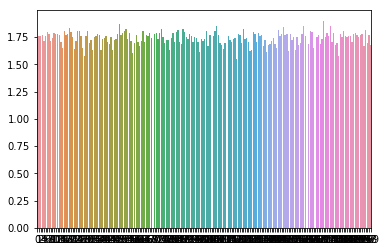

In [31]:
y = list(athletes.groupby("country")["height"].mean())
x = list(range(len(y)))
sns.barplot(x=x, y=y)

Вижда се, че за всяка държава средното за височината е различно. Това е логично, все пак в една държава хората има по-сходни гени от колкото гените на хора от различни държави.
Затова всеки спортист, който няма height попълвам със средното за държавата му, за съответния пол.

In [32]:
athletes[athletes.height.isnull()]
athletes["height"] = athletes.groupby(["country", "sex"])['height'].transform(lambda x: x.fillna(x.mean()))
athletes.isnull().sum().sort_values()

sex                 0
sport               0
gold                0
silver              0
bronze              0
country             0
population          0
gdp_per_capita      0
medals_won          0
age                 0
height             43
weight            654
dtype: int64

Оказва се, че още има непопълнени. Явно има държави за които нито един спортист няма попълнен height. Малко са, попълвам ги със общото средно.

In [33]:
athletes["height"] = athletes.height.fillna(athletes.height.mean())
athletes.isnull().sum().sort_values()

sex                 0
height              0
sport               0
gold                0
silver              0
bronze              0
country             0
population          0
gdp_per_capita      0
medals_won          0
age                 0
weight            654
dtype: int64

Остана weight. Логично е да предположим, че хората с един и същ ръст и практикуващи един и същ спорт ще имат подобно тегло.

In [34]:
athletes["weight"] =  athletes.groupby(["sport", "height"])['weight'].transform(lambda x: x.fillna(x.mean()))
athletes.isnull().sum().sort_values()

sex                 0
height              0
sport               0
gold                0
silver              0
bronze              0
country             0
population          0
gdp_per_capita      0
medals_won          0
age                 0
weight            447
dtype: int64

Явно повечето групи са с празни стойности за weight.
В такъв случай групирам само по спорт. По - слабото предположение е че хората от един и същ спорт имат подобно тегло.

In [35]:
athletes["weight"] =  athletes.groupby(["sport"])['weight'].transform(lambda x: x.fillna(x.mean()))
athletes.isnull().sum().sort_values()

sex                 0
height              0
sport               0
gold                0
silver              0
bronze              0
country             0
population          0
gdp_per_capita      0
medals_won          0
age                 0
weight            286
dtype: int64

Има още 286 спортиста без тегло, да видим кои са те.

In [36]:
print(athletes[athletes.weight.isnull()].sport.unique())
print(athletes[(athletes.sport == "boxing") & (athletes.sex == "female")].shape)
print(athletes[(athletes.sport == "boxing") & (athletes.sex == "male")].shape)

['boxing']
(36, 12)
(250, 12)


Изглежда нито един боксьор няма въведено тегло

На базата на броя боксьори участвали на олимпиадата и броя боксови категории за мъже и предполагайки равен брой боксьори 
във всяка категория оценявам средното тегло на един мъж боксьор на 69.7. Аналогично за жени - 62.

In [37]:
athletes.loc[(athletes.sport == "boxing") & (athletes.sex == "male"), "weight"] = 69.7
athletes.loc[(athletes.sport == "boxing") & (athletes.sex == "female"), "weight"] = 62

In [38]:
athletes.isnull().sum().sort_values()

sex               0
height            0
weight            0
sport             0
gold              0
silver            0
bronze            0
country           0
population        0
gdp_per_capita    0
medals_won        0
age               0
dtype: int64

Най-сетне няма повече празни стойности. Сега трябва да кодирам категорийните данни.

In [39]:
athletes_encoded = pd.get_dummies(athletes)

Махам броя медали по отделно, защото вече въведох колона за сбора им.

In [40]:
athletes_encoded = athletes_encoded.drop(["gold", "silver", "bronze"], axis=1)

Да видим как изглежда разпределението на спечелените медали.

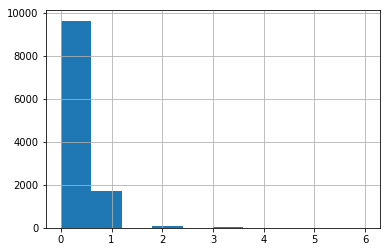

In [41]:
athletes_encoded["medals_won"].hist()

Както се очаква повечето не са спечелили нито един медал, от тези с медал най-много са спечелили един.

In [42]:
for i in range(7):
    print("{0} athletes won {1} medals".format((athletes_encoded["medals_won"]==i).sum(), i))

9645 athletes won 0 medals
1725 athletes won 1 medals
103 athletes won 2 medals
17 athletes won 3 medals
6 athletes won 4 medals
2 athletes won 5 medals
1 athletes won 6 medals


Най-сетне да тренирам модел!!! Започвам с линейна регресия.

Тъй като разпределението на медалите е толкова неравномерно трябва да се използва stratify при train_test_split. Понеже има само един атлет със 6 спечелени медал train_test_split хвърля exception, затова този атлет го махам.

In [44]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
under_achieving_athletes = athletes_encoded[athletes_encoded.medals_won < 6]
athletes_y = under_achieving_athletes["medals_won"]
athletes_x = under_achieving_athletes.drop(["medals_won"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(athletes_x, 
                                                    athletes_y,
                                                    stratify=athletes_y,
                                                    test_size=0.2, 
                                                    random_state=12313)

In [45]:
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [46]:
print("train score:", regressor.score(x_train, y_train))
print("test score: ", regressor.score(x_test, y_test))

train score: 0.122235477664
test score:  0.0965839096914


Явно няма линейна зависимост между данните (duh...).
Да пробваме с класификационни дръвца.

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
classifier = RandomForestClassifier(random_state=4222).fit(x_train, y_train)

In [48]:
print("train score:", classifier.score(x_train, y_train))
print("test score: ", classifier.score(x_test, y_test))

train score: 0.988584474886
test score:  0.878695652174


Има доста сериозен овърфитинг. Също тест скора изглежда приличен, но тъй като дейтасета не е балансиран и преобладават атлетите с 0 спечелени медала, то ако винаги казваме 0 спечелени ще има успеваемост:

In [49]:
1 - athletes_encoded[athletes_encoded.medals_won > 0].shape[0] / athletes_encoded.shape[0] 

0.8387685885729194

Тоест подобрението е около 4%. Все пак модела овърфитва, да направим GridSearch.

In [50]:
from sklearn.model_selection import GridSearchCV
import sklearn.model_selection as ms
search = GridSearchCV(RandomForestClassifier( random_state=12313), {'max_depth': [10, 20, 30, 40, 50, 60, 70],
                                                                   'n_estimators': [10, 20, 50, 100, 200, 300]}, cv=ms.StratifiedKFold(shuffle = True))
search.fit(athletes_x, athletes_y)
print(search.best_params_)
pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

/home/thalvadzhiev/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


{'max_depth': 70, 'n_estimators': 300}


/home/thalvadzhiev/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/thalvadzhiev/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/thalvadzhiev/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, 

,rank_test_score,mean_test_score,params
41,1,0.883197,"{'max_depth': 70, 'n_estimators': 300}"
35,2,0.882588,"{'max_depth': 60, 'n_estimators': 300}"
29,3,0.882414,"{'max_depth': 50, 'n_estimators': 300}"
34,4,0.882240,"{'max_depth': 60, 'n_estimators': 200}"
39,5,0.881893,"{'max_depth': 70, 'n_estimators': 100}"
33,6,0.881806,"{'max_depth': 60, 'n_estimators': 100}"
40,7,0.881632,"{'max_depth': 70, 'n_estimators': 200}"
27,8,0.881284,"{'max_depth': 50, 'n_estimators': 100}"
28,9,0.881197,"{'max_depth': 50, 'n_estimators': 200}"
26,10,0.881023,"{'max_depth': 50, 'n_estimators': 50}"


Няма много подобрение. Все пак да видим какви резултати се получават с "оптималните" параметри.

In [51]:
classifier = RandomForestClassifier(random_state=4222, max_depth=70, n_estimators=300).fit(x_train, y_train)

In [52]:
print("train score:", classifier.score(x_train, y_train))
print("test score: ", classifier.score(x_test, y_test))

train score: 0.999782561426
test score:  0.886956521739


Еха, оценката се подобри с половин-един процент!

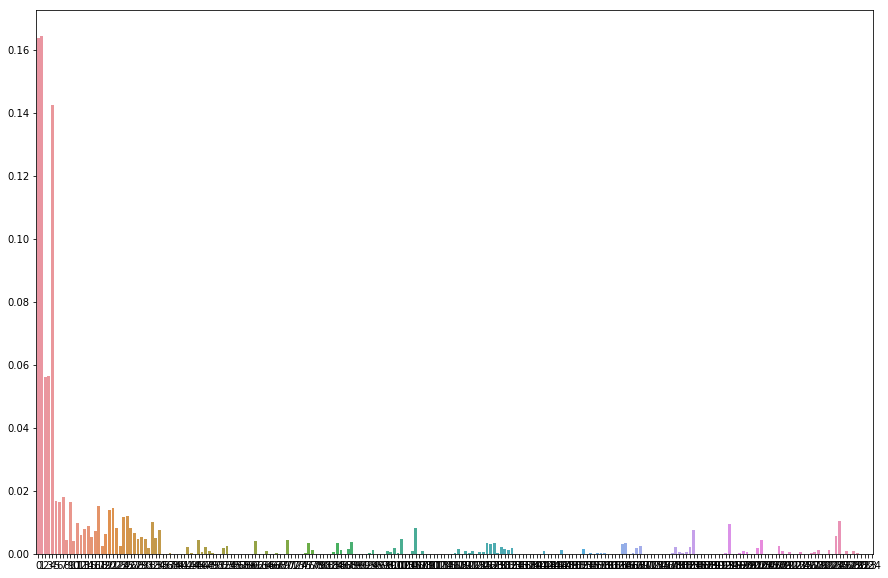

In [53]:
y = classifier.feature_importances_
x = list(range(len(y)))
fig, ax = plt.subplots(figsize=(15,10))
ax =sns.barplot(x=x, y=y, ax=ax)

Повечето от feature-ите не допринасят особено. Да видим кои са най-важните.

In [54]:
feature_importances = sorted(zip(classifier.feature_importances_, athletes_x.columns), key=lambda x: x[0], reverse=True)
feature_importances

[(0.16426003549667714, 'weight'),
 (0.16357141022131069, 'height'),
 (0.14226797317539147, 'age'),
 (0.056289184533005437, 'gdp_per_capita'),
 (0.056090171379724649, 'population'),
 (0.018139735301157645, 'sport_aquatics'),
 (0.016750929081490878, 'sex_female'),
 (0.016523518255642897, 'sex_male'),
 (0.016468891662820711, 'sport_athletics'),
 (0.015284763702939555, 'sport_football'),
 (0.014468550586775271, 'sport_hockey'),
 (0.013779142209594933, 'sport_handball'),
 (0.011992542182539935, 'sport_rugby sevens'),
 (0.011771494095833826, 'sport_rowing'),
 (0.01041417229844438, 'country_United States'),
 (0.009975874471312908, 'sport_volleyball'),
 (0.0098802346755308117, 'sport_basketball'),
 (0.009379317791724703, 'country_Serbia'),
 (0.0088341395106450189, 'sport_cycling'),
 (0.008158004933624223, 'country_Germany'),
 (0.0081567513556121754, 'sport_judo'),
 (0.0081084242289532656, 'sport_sailing'),
 (0.008001828220884662, 'sport_canoe'),
 (0.0075323303983066388, 'country_Russia'),
 (0.

Повечето държави имат почти нулева важност. По големите държави като САЩ, Германия, Русия, обаче оказват стабилно влияние. Може би ще има полза ако се добави feature "голяма държава", вместо по един за всяка държава.

In [55]:
greatest_countries = map(lambda x: x[1].replace("country_", ""), filter(lambda x: "country" in x[1], feature_importances))
greatest_countries = list(greatest_countries)[:10]
greatest_countries

['United States',
 'Serbia',
 'Germany',
 'Russia',
 'United Kingdom',
 'France',
 'Spain',
 'Canada',
 'Australia',
 'Brazil']

In [56]:
athletes_with_greatness = athletes.copy()
athletes_with_greatness["is_from_great_country"] = athletes_with_greatness.country.isin(greatest_countries)

In [57]:
athletes_with_greatness = athletes_with_greatness.drop(["country", "gold", "silver", "bronze"], axis=1)

In [58]:
athletes_with_greatness = pd.get_dummies(athletes_with_greatness)

In [59]:
under_achieving_athletes = athletes_with_greatness[athletes_with_greatness.medals_won < 6]
athletes_y = under_achieving_athletes["medals_won"]
athletes_x = under_achieving_athletes.drop(["medals_won"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(athletes_x, 
                                                    athletes_y,
                                                    stratify=athletes_y,
                                                    test_size=0.2, 
                                                    random_state=12313)

In [67]:
classifier = RandomForestClassifier(random_state=4222, max_depth=30, n_estimators=200).fit(x_train, y_train)

In [68]:
print("train score:", classifier.score(x_train, y_train))
print("test score: ", classifier.score(x_test, y_test))

train score: 0.999565122853
test score:  0.884782608696


Същата работа. Дори малко по зле.

Да опитаме и с SVC

In [69]:
from sklearn.svm import SVC
svc_classifier = SVC()
svc_classifier.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [70]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [71]:
print("train score:", svc_classifier.score(x_train_scaled, y_train))
print("test score: ", svc_classifier.score(x_test_scaled, y_test))

train score: 0.83887801696
test score:  0.838695652174


Това е точно резултата, който очакваме ако винаги казваме 0. Нека пробваме и PCA.

In [72]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(x_train_scaled)
x_pca_train = pca.transform(x_train_scaled)
x_pca_test = pca.transform(x_test_scaled)

svc_classifier = SVC(C=400)
svc_classifier.fit(x_pca_train, y_train)

SVC(C=400, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [73]:
print("train score:", svc_classifier.score(x_pca_train, y_train))
print("test score: ", svc_classifier.score(x_pca_test, y_test))

train score: 0.901174168297
test score:  0.867391304348


С известно нагаждане на C и gamma, най-добрия резултат е 86.6%.

## Втора идея.

Дали на базата на другите фийчъри мога да предскажа какъв спорт практикува атлета?
При този вариант освен теглото и височината, има шанс държавата да окаже голямо влияние. Различните държави имат различно добри школи в различни спортове. Например Етиопия и Ямайка обикновено имат най-добрите бегачи, Русия и САЩ най-добрите гимнастици и тн.

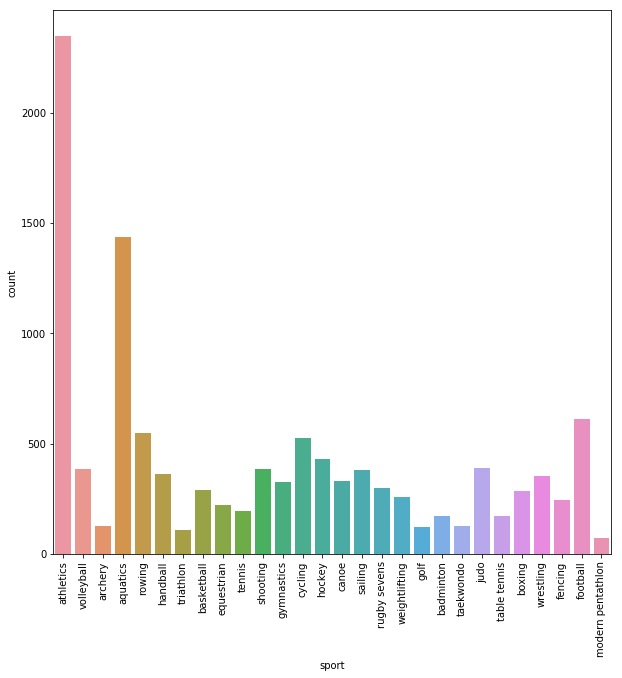

In [74]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.xticks(rotation=90)
sns.countplot("sport", data=athletes, ax=ax)

In [75]:
athletes[athletes.country=="Jamaica"].sport.unique()

array(['athletics', 'aquatics', 'gymnastics'], dtype=object)

За жалост спортните категории са твърде общи. Атлетиката има над 2300 състезателя в много различни спортове. Например бягане и скачане са в една категория. С други думи идеята, че държавата ще помогне много, няма да се получи особено добре. 

Да видим все пак какъв резултат ще получим.

In [77]:
athletes_for_sport_y = athletes["sport"]
athletes_for_sport_x = pd.get_dummies(athletes.drop(["sport", "gold", "silver", "bronze"], axis=1))

In [78]:
x_train_sport, x_test_sport, y_train_sport, y_test_sport = train_test_split(athletes_for_sport_x, 
                                                    athletes_for_sport_y,
                                                    stratify=athletes_for_sport_y,
                                                    test_size=0.2, 
                                                    random_state=12313)

In [83]:
forest_sport = RandomForestClassifier(random_state=4222, max_depth=30, n_estimators=200).fit(x_train_sport, y_train_sport)

In [84]:
print("train score:", forest_sport.score(x_train_sport, y_train_sport))
print("test score: ", forest_sport.score(x_test_sport, y_test_sport))

train score: 0.976954016741
test score:  0.410434782609


Около 41%. Дали ще подобрим резултата ако премахнем двете много общи категории.

In [85]:
athletes_no_big_clusters = athletes[~((athletes.sport == "athletics") | (athletes.sport == "aquatics"))]
athletes_for_sport_y = athletes_no_big_clusters["sport"]
athletes_for_sport_x = pd.get_dummies(athletes_no_big_clusters.drop(["sport", "gold", "silver", "bronze"], axis=1))

In [86]:
x_train_sport, x_test_sport, y_train_sport, y_test_sport = train_test_split(athletes_for_sport_x, 
                                                    athletes_for_sport_y,
                                                    stratify=athletes_for_sport_y,
                                                    test_size=0.2, 
                                                    random_state=12313)

In [87]:
forest_sport = RandomForestClassifier( random_state=4222, max_depth=30, n_estimators=200).fit(x_train_sport, y_train_sport)

In [88]:
print("train score:", forest_sport.score(x_train_sport, y_train_sport))
print("test score: ", forest_sport.score(x_test_sport, y_test_sport))

train score: 0.99805573558
test score:  0.385612443292


Не.

In [89]:
feature_importances_no_big_clusters = sorted(zip(
    forest_sport.feature_importances_, athletes_for_sport_x.columns), key=lambda x: x[0], reverse=True)
feature_importances_no_big_clusters[:10]

[(0.23872609353140015, 'weight'),
 (0.2110099340332996, 'height'),
 (0.19359633414807051, 'age'),
 (0.045345793803859849, 'gdp_per_capita'),
 (0.043928006726882268, 'medals_won'),
 (0.04183940447326228, 'population'),
 (0.013001720549844971, 'sex_female'),
 (0.012740124078162312, 'sex_male'),
 (0.004402675007362856, 'country_Sweden'),
 (0.0043215616833816887, 'country_France')]

Изглежда за спорта килограмите, височината и възрастта са най-определящи.

Остана да пробваме с SVC.

In [90]:
athletes_for_sport_y = athletes["sport"]
athletes_for_sport_x = pd.get_dummies(athletes.drop(["sport", "gold", "silver", "bronze"], axis=1))
x_train_sport, x_test_sport, y_train_sport, y_test_sport = train_test_split(athletes_for_sport_x, 
                                                    athletes_for_sport_y,
                                                    stratify=athletes_for_sport_y,
                                                    test_size=0.2, 
                                                    random_state=12313)
scaler_sport = StandardScaler().fit(x_train_sport)
x_train_scaled = scaler_sport.transform(x_train_sport)
x_test_scaled = scaler_sport.transform(x_test_sport)

In [91]:
pca = PCA(n_components=15)
pca.fit(x_train_scaled)
x_pca_train = pca.transform(x_train_scaled)
x_pca_test = pca.transform(x_test_scaled)

In [99]:
svc_classifier = SVC(C=400, gamma=0.01)
svc_classifier.fit(x_pca_train, y_train_sport)

SVC(C=400, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [100]:
print("train score:", svc_classifier.score(x_pca_train, y_train_sport))
print("test score: ", svc_classifier.score(x_pca_test, y_test_sport))

train score: 0.442004565714
test score:  0.341304347826


Справя се по-зле.

## В заключение 
* Дейтасета не съдържа достатъчно параметри на атлетите, за да може да се определи с голяма точност медалите, които ще спечелят.
* Дори в някаква степен тези груби характеристики да определят възможността за спечелване на медал, истинската формула за успех най-вероятно е доста по-неочевидна (най-малкото включва фактор генетика и надъханост, макар че се оказва че ако си млад, във форма и от богата държава имаш нелоши шансове :D)
* Определянето на спорта има нелоша успеваемост, имайки предвид че има 28 категории (на рандом шанса е 0.03, или 0.15 ако казваме винаги най-често срещания спорт). Ако имаше повече категории(например атлетиката беше разбита на повече спортове) резултата най-вероятно щеше да е по-висок.
